In [94]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
plt.style.use('ggplot')
import torch
#from acevedo_clss_and_fcns import * 
from torch.utils.data import Dataset, DataLoader
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
class my_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y):
        """
        """
        assert X.shape[0] == y.shape[0]
        
        self.X         = X
        self.y         = y

    def __len__(self):
        return len(self.y )

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        instance = self.X[idx,:]
        label  =  self.y[idx]
        return torch.tensor(instance).float(), torch.tensor(label).float()
        
        

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(10, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    



X, y                           = make_classification(n_features= 10, n_informative=3, n_samples=2000, random_state=100, flip_y=0.3)
X_train, X_0, y_train, y_0     = train_test_split(X, y, test_size=0.33, random_state=69)
X_val, X_test, y_val, y_test   = train_test_split(X_0, y_0, test_size=0.33, random_state=69)

print(X_train.shape, y_train.shape , X_val.shape , y_val.shape , X_test.shape, y_test.shape)


device = 'cuda:0'
(1340, 10) (1340,) (442, 10) (442,) (218, 10) (218,)


In [95]:
df  = pd.DataFrame(X)


df['Clase'] = y

long_df =  pd.melt(df, "Clase")

long_df.columns = ["Clase", "Variable","Valor"]

<AxesSubplot:xlabel='Variable', ylabel='Valor'>

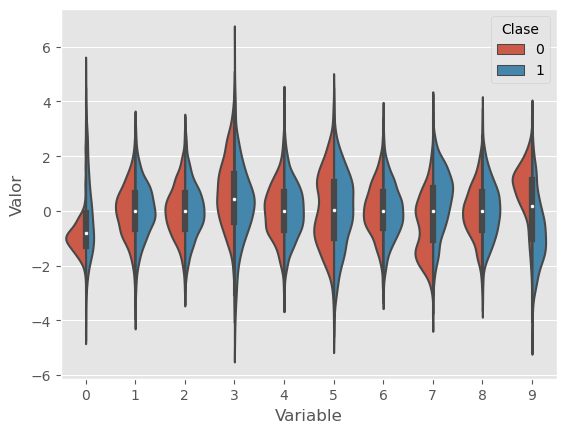

In [96]:
import seaborn as sns
df = sns.load_dataset("titanic")
sns.violinplot(data=long_df, x="Variable", y="Valor", hue="Clase", split=True)


In [97]:
train_dataloader = DataLoader(my_dataset(X_train,y_train), batch_size=4*32, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(my_dataset(X_val,y_val), batch_size=4*32, shuffle=True, drop_last=True)
model = BinaryClassification().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
EPOCHS = 50
train_accuracy = []
val_accuracy   = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()        
        y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))        
        loss.backward()
        optimizer.step()        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    train_accuracy.append(epoch_acc/len(train_dataloader))
    
    model.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0
    for X_batch, y_batch in val_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
        val_y_pred = model(X_batch)
            
        loss = criterion(val_y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(val_y_pred, y_batch.unsqueeze(1))

        val_epoch_loss += loss.item()
        val_epoch_acc += acc.item()
        
    val_accuracy.append(val_epoch_acc/len(val_dataloader))    


test_dataloader  = DataLoader(my_dataset(X_test,y_test), batch_size=4*32, shuffle=True, drop_last=True)
model.eval()
all_predictions = []
all_true        = []
tprs            = []
aucs = []
base_fpr = np.linspace(0, 1, 101)



In [98]:


for X_batch, y_batch in test_dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)                       

    val_predictions = model(X_batch)# Make predictions for this batch
    #pred            = val_predictions.argmax(dim=1)
    
    #y_pred_tag = torch.round(torch.sigmoid(val_predictions)).squeeze().cpu().int().tolist()
    y_pred_tag = val_predictions.squeeze().cpu().int().tolist()
    y_true     = y_batch.squeeze().cpu().int().tolist()
    #print(y_true, y_pred_tag)    
    fpr, tpr, _ = roc_curve(y_true, y_pred_tag)
    
    
    #print(y_pred_tag, y_true, tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)


tprs_upper = np.minimum(mean_tprs + tprs.std(axis=0), 1)
tprs_lower = mean_tprs - tprs.std(axis=0)


In [99]:



from torchviz import make_dot

yhat = model(X_batch)

make_dot(yhat, params=dict(model.named_parameters()), show_attrs=False, show_saved=False).render("example_NN", format='png')
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox


def place_image(im, loc=10, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='center', child=imagebox, pad=0., borderpad =0, frameon=False)
    ax.add_artist(ab)

In [100]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
gs = GradientShap(model)
# We define a distribution of baselines and draw `n_samples` from that
# distribution in order to estimate the expectations of gradients across all baselines
baseline_dist = torch.randn(1, 10).to(device=device) #* 0.000001
input = torch.rand(1, 10).to(device=device)
attributions, delta = gs.attribute(input, stdevs=0.09, n_samples=500, baselines=baseline_dist,
                                   target=0, return_convergence_delta=True)

weights = pd.Series(attributions.squeeze().cpu().numpy())#.plot.bar()


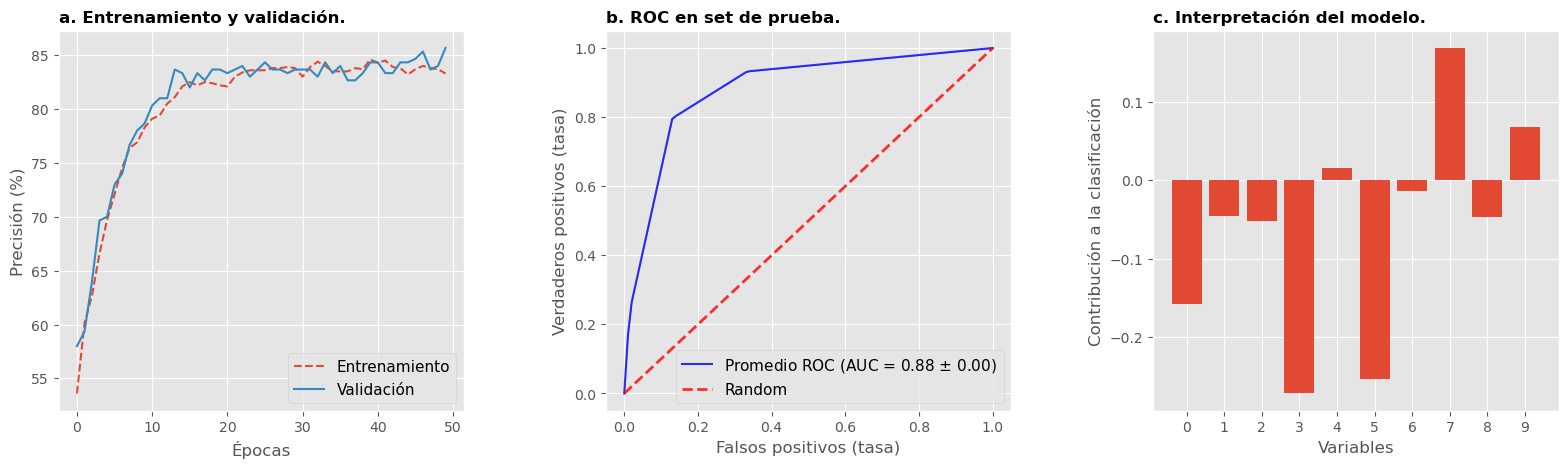

In [101]:

fig = plt.figure(figsize=(25,4))
#ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
#ax4 = plt.subplot2grid((1, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.7, top=1.05, wspace=0.35, hspace=0.45)    
    
#ax0.axis('off')
#graph_1 = image.imread( "./example_NN.png")
#plt.imshow(graph_1)

#place_image(graph_1, loc=1, ax=ax0, pad=0, zoom=0.42)
    
ax1.plot(train_accuracy,  label = "Entrenamiento", linestyle="--")
ax1.plot(val_accuracy,  label = "Validación", linestyle="-")
ax1.legend(loc="lower right", fontsize=11)
ax1.set_ylabel('Precisión (%)')
ax1.set_xlabel("Épocas")
ax1.set_title("a. Entrenamiento y validación.", fontsize = 12,  fontweight ="bold", loc='left')


def put_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Promedio ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=11)
    AX.set_ylabel('Verdaderos positivos (tasa)')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')
    
put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax2, xlabel = 'Falsos positivos (tasa)', letter = 'b. ROC en set de prueba.')

ax3.bar(weights.index.values.astype(str), height = weights)
ax3.set_ylabel("Contribución a la clasificación")
ax3.set_xlabel("Variables")
ax3.set_title("c. Interpretación del modelo.", fontsize = 12,  fontweight ="bold", loc='left')




plt.savefig("./example.png",
            bbox_inches ="tight",
            pad_inches = 0.01,
            transparent = False,
             dpi=250)

plt.show()